In [11]:
# %%
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D  # Necessary for 3D plotting


In [12]:
# %%
# Load the dataset
data = pd.read_csv("/Users/rooj/Documents/RP3-Main/RP3-Data/CSE-CIC-IDS2018/DoS-Related/02-15-2018.csv")  # Update with your dataset's path

# Preview the data
print(data.head())
print(data.info())
print(data['Label'].value_counts())

   Dst Port  Protocol            Timestamp  Flow Duration  Tot Fwd Pkts  \
0         0         0  15/02/2018 08:25:18      112641158             3   
1        22         6  15/02/2018 08:29:05       37366762            14   
2     47514         6  15/02/2018 08:29:42            543             2   
3         0         0  15/02/2018 08:28:07      112640703             3   
4         0         0  15/02/2018 08:30:56      112640874             3   

   Tot Bwd Pkts  TotLen Fwd Pkts  TotLen Bwd Pkts  Fwd Pkt Len Max  \
0             0                0                0                0   
1            12             2168             2993              712   
2             0               64                0               64   
3             0                0                0                0   
4             0                0                0                0   

   Fwd Pkt Len Min  ...  Fwd Seg Size Min  Active Mean     Active Std  \
0                0  ...                 0          0.0 

In [13]:
# Map labels to integers
label_mapping = {'Benign': 0, 'DoS attacks-GoldenEye': 1, 'DoS attacks-Slowloris': 2}
data['Label'] = data['Label'].map(label_mapping)

# Filter for relevant classes (in case there are additional classes in the dataset)
data = data[data['Label'].isin([0, 1, 2])]  # Keep only the desired classes

print("Encoded class distribution:\n", data['Label'].value_counts())

# Balance the dataset (Place here!)
# Undersample the majority class
majority_class = data[data['Label'] == 0]
minority_class_1 = data[data['Label'] == 1]
minority_class_2 = data[data['Label'] == 2]

# Randomly sample from the majority class
majority_class_sampled = majority_class.sample(n=len(minority_class_1) * 2, random_state=42)  # Adjust the sampling ratio

# Combine all classes
balanced_data = pd.concat([majority_class_sampled, minority_class_1, minority_class_2], axis=0)

print("Balanced class distribution:\n", balanced_data['Label'].value_counts())

# Proceed with Feature Selection
selected_features = [
    'Flow Duration', 'Fwd Pkt Len Mean', 'Bwd Pkt Len Std',
    'Pkt Size Avg', 'Flow IAT Mean'
]

X = balanced_data[selected_features]
y = balanced_data['Label']

# Preprocessing: Scaling, PCA, and K-Means follow here


Encoded class distribution:
 Label
0    996077
1     41508
2     10990
Name: count, dtype: int64
Balanced class distribution:
 Label
0    83016
1    41508
2    10990
Name: count, dtype: int64


In [14]:
# %%
# Handle missing values
X = X.dropna()

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# %%
# Apply PCA
pca = PCA(n_components=2)  # of components for visualization
X_pca = pca.fit_transform(X_scaled)
print(f'Explained variance ratio: {pca.explained_variance_ratio_}')

Explained variance ratio: [0.46423255 0.30706712]


/Users/rooj/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/rooj/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/rooj/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/rooj/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to

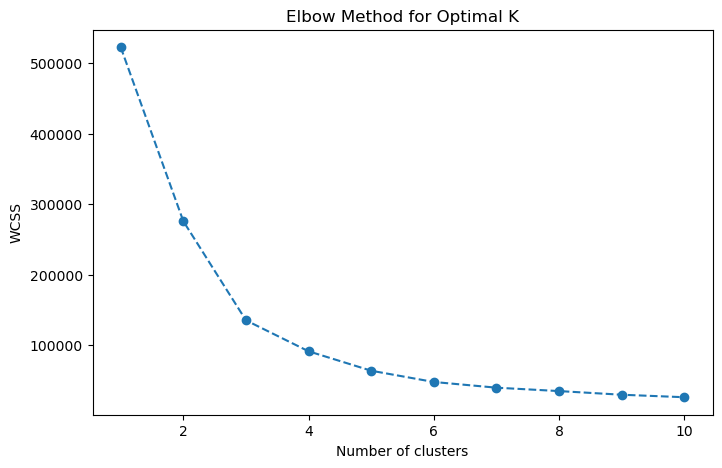

In [15]:
# %%
# Determine the optimal number of clusters using the Elbow Method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X_pca)
    wcss.append(kmeans.inertia_)

# Plot the Elbow graph
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


In [16]:
# Use the indices from the original dataset (X) before PCA
data_subset = data.iloc[X.index]  # Align with the rows used for PCA

# Apply K-Means clustering
optimal_clusters = 5
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', random_state=42)
cluster_labels = kmeans.fit_predict(X_pca)

# Add cluster labels to the subset data
data_subset = data_subset.copy()  # Avoid SettingWithCopyWarning
data_subset['Cluster'] = cluster_labels

print(data_subset.head())


/Users/rooj/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


        Dst Port  Protocol            Timestamp  Flow Duration  Tot Fwd Pkts  \
232347         0         0  15/02/2018 09:26:21      112636771             3   
881090        53        17  15/02/2018 10:32:08           1249             1   
441260     51224         6  15/02/2018 11:31:10            145             2   
415071        80         6  15/02/2018 09:11:27            685             3   
427924        53        17  15/02/2018 12:54:35            464             1   

        Tot Bwd Pkts  TotLen Fwd Pkts  TotLen Bwd Pkts  Fwd Pkt Len Max  \
232347             0                0                0                0   
881090             1               51              136               51   
441260             0                0                0                0   
415071             4              161              488              161   
427924             1               46               62               46   

        Fwd Pkt Len Min  ...  Active Mean  Active Std  Active Max  A

In [17]:
sample_size = 10000
print(len(X_pca))

# Ensure the sample size does not exceed the dataset size
if len(X_pca) > sample_size:
    # Randomly select a subset of indices
    sample_indices = np.random.choice(len(X_pca), size=sample_size, replace=False)
    X_sample = X_pca[sample_indices]
    labels_sample = cluster_labels[sample_indices]
else:
    X_sample = X_pca
    labels_sample = cluster_labels

# Compute the Silhouette Score on the sample
sil_score = silhouette_score(X_sample, labels_sample)
print(f'Silhouette Score (sample of {len(X_sample)}): {sil_score}')

135514
Silhouette Score (sample of 10000): 0.6954800917348741


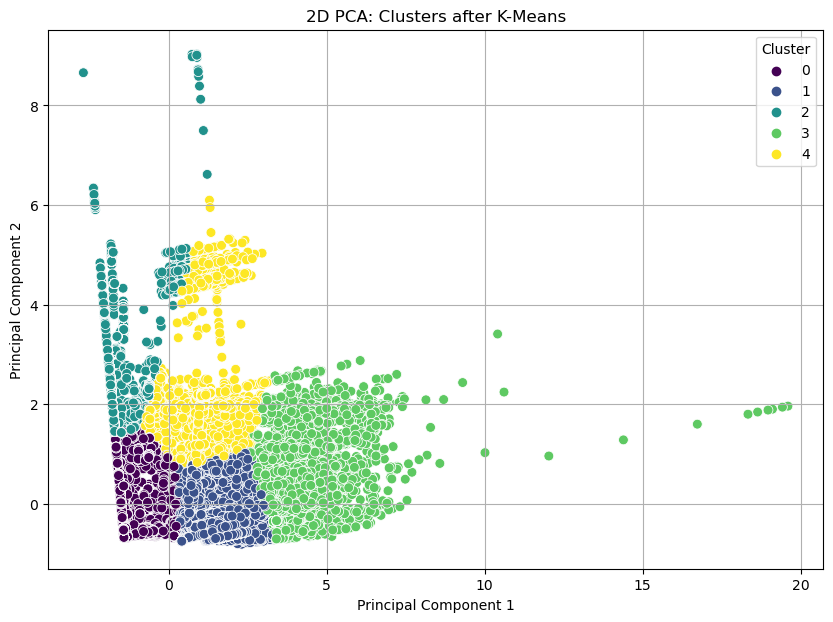

In [18]:

# %%
# Assuming X_pca is your PCA-transformed data and cluster_labels are the labels from K-Means
n_components = X_pca.shape[1]

if n_components == 2:
    # 2D Scatter Plot
    plt.figure(figsize=(10, 7))
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=cluster_labels, palette='viridis', s=50)
    plt.title('2D PCA: Clusters after K-Means')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(title='Cluster')
    plt.grid(True)
    plt.show()

elif n_components == 3:
    # 3D Scatter Plot
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=cluster_labels, cmap='viridis', s=50)
    ax.set_title('3D PCA: Clusters after K-Means')
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')
    legend1 = ax.legend(*scatter.legend_elements(), title="Cluster")
    ax.add_artist(legend1)
    plt.show()

else:
    print(f"Visualization for {n_components} components is not supported.")


In [19]:
# Ensure data and X_pca indices match
data_subset = data.iloc[X.index].copy()  # Create a subset of the original data

# Assign cluster labels to the subset
data_subset['Cluster'] = cluster_labels  # Add cluster labels to the subset

# Align cluster labels to the majority class
def align_clusters(data_subset, label_names):
    # Map clusters to their majority label
    cluster_mapping = (
        data_subset.groupby('Cluster')['Label']
        .apply(lambda x: x.value_counts().idxmax())
        .to_dict()
    )
    
    # Map cluster numbers to human-readable labels
    cluster_label_mapping = {cluster: label_names[true_label] for cluster, true_label in cluster_mapping.items()}
    
    # Replace numeric labels in 'Label' column with human-readable labels
    data_subset['Mapped Label'] = data_subset['Label'].map(label_names)
    
    # Map cluster labels to their aligned labels
    data_subset['Aligned Cluster'] = data_subset['Cluster'].map(cluster_mapping)
    
    return cluster_mapping, cluster_label_mapping, data_subset

# Label names (for readability)
label_names = {0: "Benign", 1: "DoS-GoldenEye", 2: "DoS-Slowloris"}

# Align clusters for Normal K-Means
normal_mapping, normal_label_mapping, data_normal = align_clusters(data_subset, label_names)
print("Cluster Mapping (Normal):", normal_label_mapping)

# Analyze cluster composition (ensure all clusters and labels are included)
cluster_composition_normal = (
    data_normal.groupby('Cluster')['Mapped Label']
    .value_counts(normalize=True)
    .unstack(fill_value=0)  # Fill missing entries with 0
)
print("Cluster Composition (Aligned - Normal):\n", cluster_composition_normal)




Cluster Mapping (Normal): {0: 'Benign', 1: 'DoS-GoldenEye', 2: 'Benign', 3: 'Benign', 4: 'DoS-Slowloris'}
Cluster Composition (Aligned - Normal):
 Mapped Label    Benign  DoS-GoldenEye  DoS-Slowloris
Cluster                                             
0             0.805861       0.150303       0.043836
1             0.277615       0.718384       0.004000
2             0.414983       0.280004       0.305013
3             0.784965       0.192092       0.022944
4             0.449691       0.069381       0.480928


In [20]:
# %%
# Save the PCA and KMeans models for future use
import joblib
joblib.dump(pca, 'pca_model.pkl')
joblib.dump(kmeans, 'kmeans_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
print("Models saved successfully.")

Models saved successfully.
